
# Classification d'Images par Couleur (HSV/RGB) avec SVM — Version Reformulée

Notebook **entièrement réécrit** (noms, commentaires, structure) pour : dataset → features RGB/HSV → SVM → baseline Hue → métriques & figures.


In [1]:

from pathlib import Path
import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

SEED, IMG_SIZE = 123, 128
ROOT = Path("data")
CLASSES = ["mer", "paysage", "desert"]
LABELS = {c:i for i,c in enumerate(CLASSES)}

ARTIFACTS = Path("sorties_reformule"); ARTIFACTS.mkdir(parents=True, exist_ok=True)

print("Dataset:", ROOT.resolve())
for c in CLASSES:
    print(c, len(list((ROOT/c).glob("*"))))


Dataset: C:\Users\Chihab\Desktop\projet DL-SVM_CV_Nature\data
mer 10
paysage 10
desert 10


In [2]:

def show_image_grid(paths, cols=5, title=None):
    paths = list(paths)[:max(cols, len(paths))]
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=(3.5*cols, 3*rows))
    for i, p in enumerate(paths, 1):
        img = cv2.imread(str(p))
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i); plt.imshow(img); plt.axis('off'); plt.title(Path(p).parent.name)
    if title: plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()


In [3]:

def rgb_hists(img_bgr, bins=16):
    h_b = cv2.calcHist([img_bgr],[0],None,[bins],[0,256]).flatten()
    h_g = cv2.calcHist([img_bgr],[1],None,[bins],[0,256]).flatten()
    h_r = cv2.calcHist([img_bgr],[2],None,[bins],[0,256]).flatten()
    h = np.concatenate([h_r, h_g, h_b]).astype(np.float32)
    return h / (h.sum() + 1e-12)

def hsv_hists(img_bgr, h_bins=36, s_bins=16, v_bins=16):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h_h = cv2.calcHist([hsv],[0],None,[h_bins],[0,180]).flatten()
    h_s = cv2.calcHist([hsv],[1],None,[s_bins],[0,256]).flatten()
    h_v = cv2.calcHist([hsv],[2],None,[v_bins],[0,256]).flatten()
    h = np.concatenate([h_h, h_s, h_v]).astype(np.float32)
    return h / (h.sum() + 1e-12)

def channel_moments(img, space='BGR'):
    if space == 'BGR':
        chs = [img[:,:,i] for i in range(3)]
    else:
        chs = [img[:,:,0], img[:,:,1], img[:,:,2]]
    means = [c.mean() for c in chs]; stds  = [c.std()  for c in chs]
    return np.array(means + stds, dtype=np.float32)

H_RANGES = {"mer":(100,140), "paysage":(50,90), "desert":(10,40)}

def hue_ratios(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H = hsv[:,:,0]; total = H.size
    ratios = []
    for c in CLASSES:
        lo, hi = H_RANGES[c]
        r = np.sum((H >= lo) & (H < hi)) / total
        ratios.append(r)
    return np.array(ratios, dtype=np.float32)

def build_features(img_bgr):
    im = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    rgb_feat = np.concatenate([rgb_hists(im, 16), channel_moments(im, 'BGR')])
    hsv_img = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    hsv_feat = np.concatenate([hsv_hists(im, 36, 16, 16), channel_moments(hsv_img, 'HSV'), hue_ratios(im)])
    return rgb_feat.astype(np.float32), hsv_feat.astype(np.float32)


Shapes: (30, 54) (30, 77) (30,)


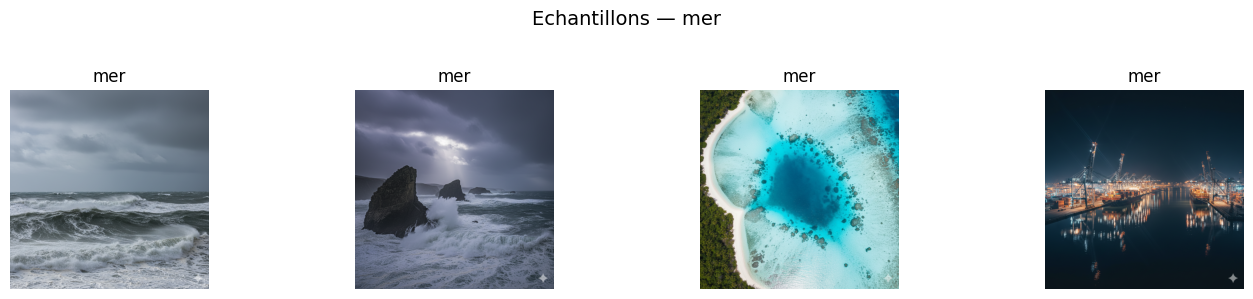

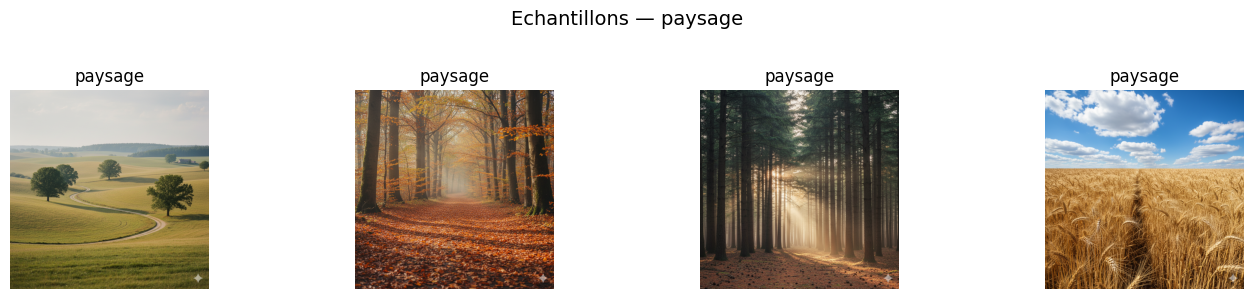

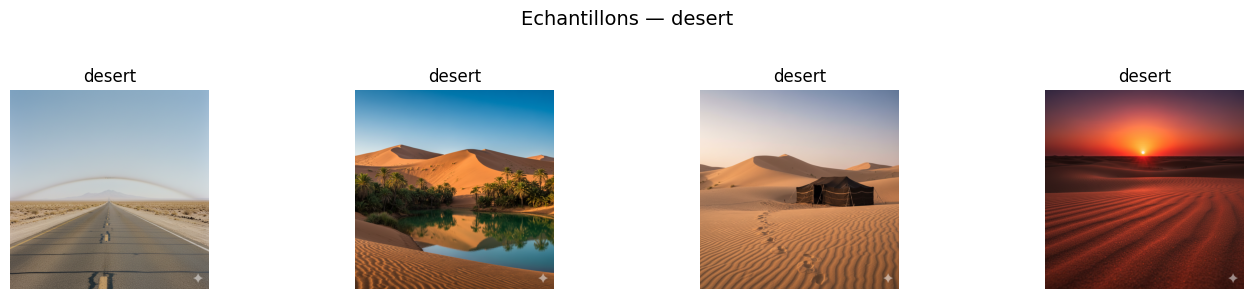

In [4]:

X_rgb, X_hsv, Y, paths = [], [], [], []
for cls in CLASSES:
    for p in (ROOT/cls).glob("*"):
        img = cv2.imread(str(p))
        if img is None: continue
        frgb, fhsv = build_features(img)
        X_rgb.append(frgb); X_hsv.append(fhsv); Y.append(LABELS[cls]); paths.append(str(p))

X_rgb = np.stack(X_rgb) if len(X_rgb) else np.empty((0,54), dtype=np.float32)
X_hsv = np.stack(X_hsv) if len(X_hsv) else np.empty((0,77), dtype=np.float32)
Y = np.array(Y, dtype=np.int64)

print("Shapes:", X_rgb.shape, X_hsv.shape, Y.shape)

for cls in CLASSES:
    cand = sorted((ROOT/cls).glob("*"))[:4]
    if cand: show_image_grid(cand, cols=4, title=f"Echantillons — {cls}")


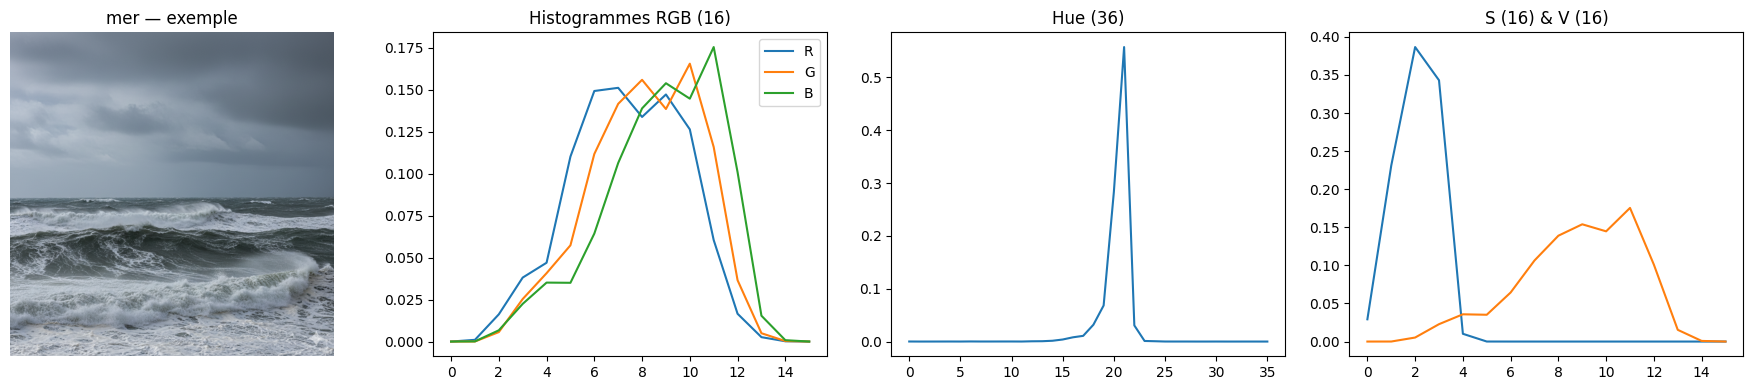

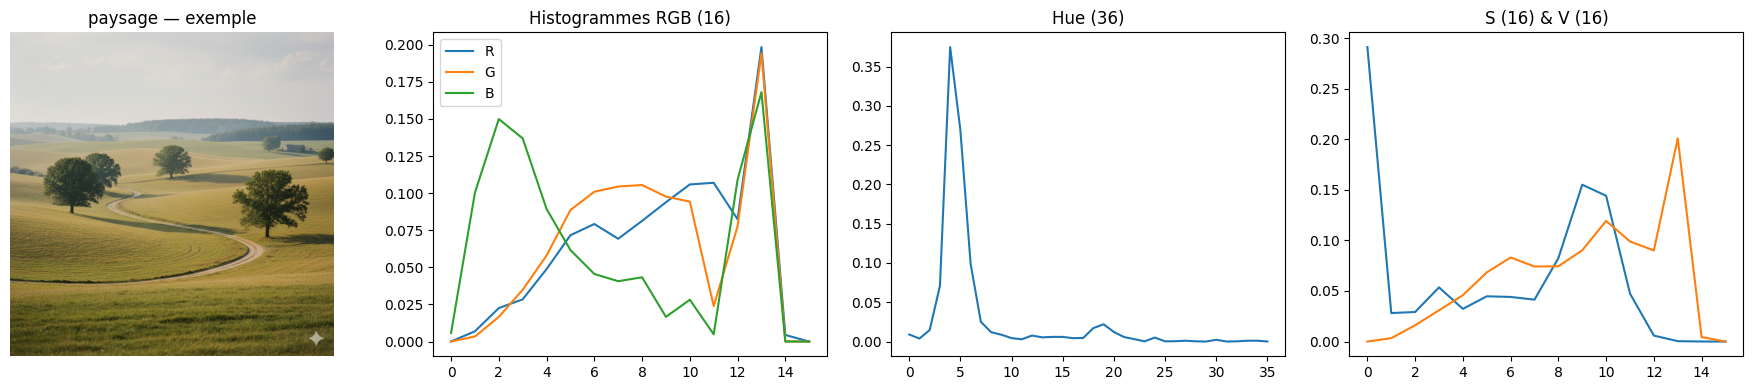

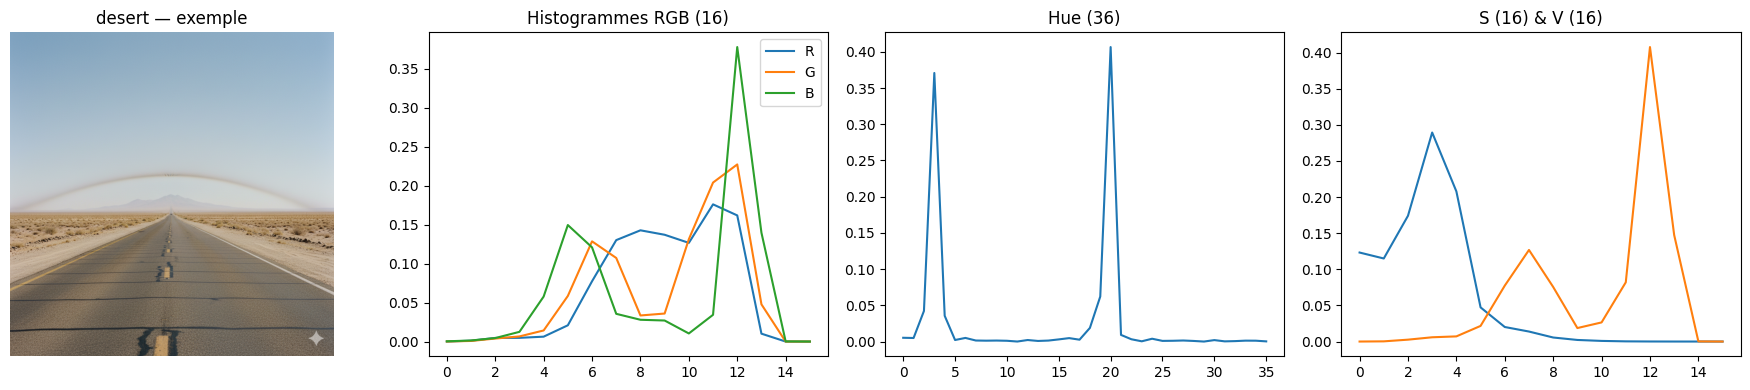

In [5]:

def plot_exploration_for_one(path_img, out_name):
    img = cv2.imread(str(path_img))
    if img is None: return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    fig, ax = plt.subplots(1, 4, figsize=(18,4))
    ax[0].imshow(img_rgb); ax[0].set_title(f"{Path(path_img).parent.name} — exemple"); ax[0].axis('off')

    for i, lab in zip([2,1,0], ["R","G","B"]):
        h = cv2.calcHist([img],[i],None,[16],[0,256]).flatten(); h /= (h.sum()+1e-12)
        ax[1].plot(h, label=lab)
    ax[1].set_title("Histogrammes RGB (16)"); ax[1].legend()

    h_h = cv2.calcHist([hsv],[0],None,[36],[0,180]).flatten(); h_h/= (h_h.sum()+1e-12)
    h_s = cv2.calcHist([hsv],[1],None,[16],[0,256]).flatten(); h_s/= (h_s.sum()+1e-12)
    h_v = cv2.calcHist([hsv],[2],None,[16],[0,256]).flatten(); h_v/= (h_v.sum()+1e-12)
    ax[2].plot(h_h); ax[2].set_title("Hue (36)")
    ax[3].plot(h_s); ax[3].plot(h_v); ax[3].set_title("S (16) & V (16)")

    fig.tight_layout()
    fig.savefig(Path(ARTIFACTS)/out_name, dpi=300)
    plt.show()

for cls in CLASSES:
    files = list((ROOT/cls).glob("*"))
    if files:
        plot_exploration_for_one(files[0], f"exploration_{cls}.png")


In [6]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Xr_tr, Xr_te, Xh_tr, Xh_te, y_tr, y_te, p_tr, p_te = train_test_split(
    X_rgb, X_hsv, Y, paths, test_size=0.2, random_state=SEED, stratify=Y
)

def make_svm():
    return Pipeline([("scaler", StandardScaler()),
                     ("svc", SVC(kernel="rbf", random_state=SEED))])

param_grid = {"svc__C":[1,10,100], "svc__gamma":[1e-3,1e-2,1e-1]}

grid_rgb = GridSearchCV(make_svm(), param_grid, cv=4, n_jobs=-1, verbose=0)
grid_hsv = GridSearchCV(make_svm(), param_grid, cv=4, n_jobs=-1, verbose=0)

grid_rgb.fit(Xr_tr, y_tr); grid_hsv.fit(Xh_tr, y_tr)
print("Best RGB:", grid_rgb.best_params_, "CV:", grid_rgb.best_score_)
print("Best HSV:", grid_hsv.best_params_, "CV:", grid_hsv.best_score_)


Best RGB: {'svc__C': 10, 'svc__gamma': 0.001} CV: 0.5833333333333334
Best HSV: {'svc__C': 10, 'svc__gamma': 0.01} CV: 0.625


=== SVM-RGB ===
Accuracy: 0.16666666666666666 | Macro-F1: 0.2222222222222222
              precision    recall  f1-score   support

         mer       1.00      0.50      0.67         2
     paysage       0.00      0.00      0.00         2
      desert       0.00      0.00      0.00         2

    accuracy                           0.17         6
   macro avg       0.33      0.17      0.22         6
weighted avg       0.33      0.17      0.22         6

=== SVM-HSV ===
Accuracy: 0.3333333333333333 | Macro-F1: 0.19047619047619047
              precision    recall  f1-score   support

         mer       0.40      1.00      0.57         2
     paysage       0.00      0.00      0.00         2
      desert       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.13      0.33      0.19         6
weighted avg       0.13      0.33      0.19         6



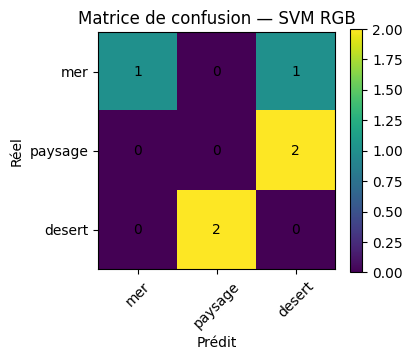

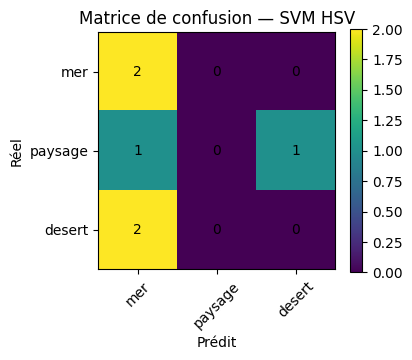

In [7]:

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np, matplotlib.pyplot as plt

def evaluate(model, Xte, yte, tag):
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    p, r, f1, _ = precision_recall_fscore_support(yte, pred, average="macro", zero_division=0)
    print(f"=== {tag} ===")
    print("Accuracy:", acc, "| Macro-F1:", f1)
    print(classification_report(yte, pred, target_names=CLASSES, zero_division=0))
    cm = confusion_matrix(yte, pred, labels=[0,1,2])
    return pred, cm, acc, f1

pred_rgb, cm_rgb, acc_rgb, f1_rgb = evaluate(grid_rgb, Xr_te, y_te, "SVM-RGB")
pred_hsv, cm_hsv, acc_hsv, f1_hsv = evaluate(grid_hsv, Xh_te, y_te, "SVM-HSV")

def plot_cm(cm, title, outfile):
    plt.figure(figsize=(4.2,3.6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES, rotation=45)
    plt.yticks(tick_marks, CLASSES)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha='center', va='center')
    plt.ylabel('Réel'); plt.xlabel('Prédit')
    plt.tight_layout(); plt.savefig(Path(ARTIFACTS)/outfile, dpi=300); plt.show()

plot_cm(cm_rgb, "Matrice de confusion — SVM RGB", "cm_rgb.png")
plot_cm(cm_hsv, "Matrice de confusion — SVM HSV", "cm_hsv.png")


Baseline Hue — Acc: 0.5 | Macro-F1: 0.4444444444444444


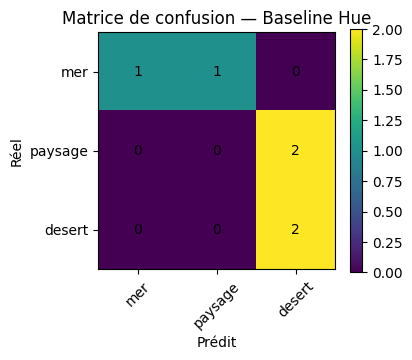

In [8]:

H_RANGES = {"mer":(100,140), "paysage":(50,90), "desert":(10,40)}
HUE_THRESH = 0.40

def hue_rule_predict(img_path):
    img = cv2.imread(str(img_path))
    if img is None: return None
    hsv = cv2.cvtColor(cv2.resize(img, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2HSV)
    H = hsv[:,:,0]
    portions = []
    for cls in CLASSES:
        lo, hi = H_RANGES[cls]
        portions.append(np.sum((H >= lo) & (H < hi)) / H.size)
    portions = np.array(portions)
    return int(np.argmax(portions))

pred_hue = np.array([hue_rule_predict(p) for p in p_te], dtype=int)
acc_hue = accuracy_score(y_te, pred_hue)
p_m, r_m, f1_hue, _ = precision_recall_fscore_support(y_te, pred_hue, average="macro", zero_division=0)

print("Baseline Hue — Acc:", acc_hue, "| Macro-F1:", f1_hue)
cm_hue = confusion_matrix(y_te, pred_hue, labels=[0,1,2])
plot_cm(cm_hue, "Matrice de confusion — Baseline Hue", "cm_hue.png")


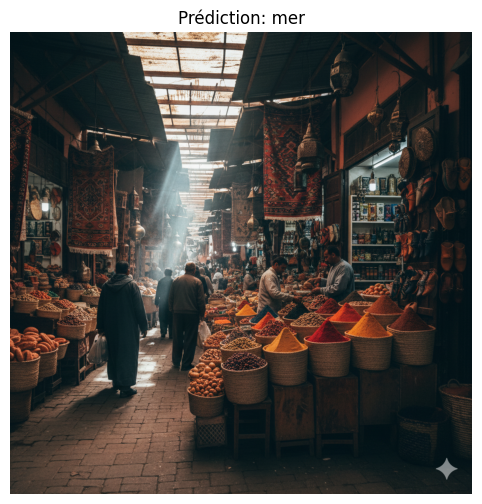

Image classifiée comme: mer


In [13]:
# Chargement et prétraitement de l'image externe
new_image_path = r"C:\Users\Chihab\Desktop\projet DL-SVM_CV_Nature\photo_inconnue.png"
new_img = cv2.imread(new_image_path)

# Application des mêmes prétraitements
new_img_resized = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

# Extraction des features (même méthode que pendant l'entraînement)
_, new_features_hsv = build_features(new_img)

# Prédiction avec le meilleur modèle (HSV)
prediction = grid_hsv.predict([new_features_hsv])
predicted_class = CLASSES[prediction[0]]

# Affichage
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title(f"Prédiction: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Image classifiée comme: {predicted_class}")


etape 7:

In [14]:
# Calcul des métriques détaillées
def comprehensive_evaluation(model, Xte, yte, tag):
    pred = model.predict(Xte)
    
    # Métriques globales
    acc = accuracy_score(yte, pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        yte, pred, average="macro", zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        yte, pred, average="weighted", zero_division=0
    )
    
    print(f"=== {tag} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Macro-Precision: {precision_macro:.3f}")
    print(f"Macro-Recall: {recall_macro:.3f}")
    print(f"Macro-F1: {f1_macro:.3f}")
    print(f"Weighted-F1: {f1_weighted:.3f}")
    
    return {
        'Accuracy': acc,
        'Macro-Precision': precision_macro,
        'Macro-Recall': recall_macro,
        'Macro-F1': f1_macro,
        'Weighted-F1': f1_weighted
    }

# Application aux deux modèles
metrics_rgb = comprehensive_evaluation(grid_rgb, Xr_te, y_te, "SVM-RGB")
metrics_hsv = comprehensive_evaluation(grid_hsv, Xh_te, y_te, "SVM-HSV")

# Tableau récapitulatif
summary_comprehensive = pd.DataFrame({
    'Modèle': ['SVM-RGB', 'SVM-HSV'],
    'Accuracy': [metrics_rgb['Accuracy'], metrics_hsv['Accuracy']],
    'Macro-Precision': [metrics_rgb['Macro-Precision'], metrics_hsv['Macro-Precision']],
    'Macro-Recall': [metrics_rgb['Macro-Recall'], metrics_hsv['Macro-Recall']],
    'Macro-F1': [metrics_rgb['Macro-F1'], metrics_hsv['Macro-F1']]
})

print("\n" + "="*50)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("="*50)
display(summary_comprehensive)

# Export des résultats
summary_comprehensive.to_csv(Path(ARTIFACTS)/"validation_complete.csv", index=False)

=== SVM-RGB ===
Accuracy: 0.167
Macro-Precision: 0.333
Macro-Recall: 0.167
Macro-F1: 0.222
Weighted-F1: 0.222
=== SVM-HSV ===
Accuracy: 0.333
Macro-Precision: 0.133
Macro-Recall: 0.333
Macro-F1: 0.190
Weighted-F1: 0.190

TABLEAU RÉCAPITULATIF DES PERFORMANCES


,Modèle,Accuracy,Macro-Precision,Macro-Recall,Macro-F1
0,SVM-RGB,0.166667,0.333333,0.166667,0.222222
1,SVM-HSV,0.333333,0.133333,0.333333,0.190476


In [9]:

import pandas as pd
summary = pd.DataFrame({
    "Modèle": ["Baseline Hue", "SVM-RGB", "SVM-HSV"],
    "Accuracy": [acc_hue, acc_rgb, acc_hsv],
    "Macro-F1": [f1_hue, f1_rgb, f1_hsv]
})
display(summary)
summary.to_csv(Path(ARTIFACTS)/"scores_recapitulatif.csv", index=False)
print("→ Export:", (Path(ARTIFACTS)/"scores_recapitulatif.csv").resolve())


,Modèle,Accuracy,Macro-F1
0,Baseline Hue,0.500000,0.444444
1,SVM-RGB,0.166667,0.222222
2,SVM-HSV,0.333333,0.190476


→ Export: C:\Users\Chihab\Desktop\projet DL-SVM_CV_Nature\sorties_reformule\scores_recapitulatif.csv
